# Benchmarking Read/Write of Geospatial Data Formats
 
Writing large geopackages can take forever with GeoPandas. How do other formats/engines stack up?

Jonathan Markel  
3D Geospatial Laboratory  
The University of Texas at Austin  
08/30/2023

##### [Twitter](https://twitter.com/jonm3d) | [GitHub](https://github.com/jonm3d) | [Website](http://j3d.space) | [GoogleScholar](https://scholar.google.com/citations?user=KwxwFgYAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/j-markel/) 

In [1]:
# pip install pyogrio

In [7]:
import os
import timeit
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
path_to_file = "/home/jovyan/geobench/data/larger.gpkg"
bench_dir = "/home/jovyan/geobench/outputs"

def write_geo_data(df, filename, format, driver, use_pyogrio=True):
    engine = "pyogrio" if use_pyogrio else None
    gdf_to_save = df.copy()
    
    # Convert datetime column to string
    if 'time' in gdf_to_save.columns:
        gdf_to_save['time'] = gdf_to_save['time'].astype(str)
    
    # Handle column naming restrictions for ESRI Shapefile
    if format == 'shapefile':
        for col in gdf_to_save.columns:
            if len(col) > 10:
                gdf_to_save.rename(columns={col: col[:10]}, inplace=True)
    
    if format == 'parquet':
        gdf_to_save.to_parquet(os.path.join(bench_dir, filename))
    else:
        gdf_to_save.to_file(os.path.join(bench_dir, filename), driver=driver, engine=engine)

def read_geo_data(filename, format, use_pyogrio=True):
    engine = "pyogrio" if use_pyogrio else None
    
    if format == 'parquet':
        gdf = gpd.read_parquet(os.path.join(bench_dir, filename))
    else:
        gdf = gpd.read_file(os.path.join(bench_dir, filename), engine=engine)
    
    # Convert string column back to datetime
    if 'time' in gdf.columns:
        gdf['time'] = pd.to_datetime(gdf['time'])
    
    return gdf

# Load the dataframe
df = gpd.read_file(path_to_file, engine="pyogrio")

number_of_repeats = 5

formats = [
    {'filename': 'test.parquet', 'format': 'parquet', 'driver': None, 'label': 'parquet'},
    {'filename': 'test.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg (pyogrio)'},
    {'filename': 'test.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg', 'use_pyogrio': False},
    {'filename': 'test.shp', 'format': 'shapefile', 'driver': 'ESRI Shapefile', 'label': 'shp (pyogrio)'},
    {'filename': 'test.shp', 'format': 'shapefile', 'driver': 'ESRI Shapefile', 'label': 'shp', 'use_pyogrio': False},
    # {'filename': 'test.fgb', 'format': 'flatgeobuf', 'driver': 'FlatGeobuf', 'label': 'fgb'}
]

write_results = []
read_results = []

for fmt in formats:
    print(f"Benchmarking {fmt['label']} write...")
    write_time = timeit.timeit(lambda: write_geo_data(df, fmt['filename'], fmt['format'], fmt['driver'], fmt.get('use_pyogrio', True)), number=number_of_repeats) / number_of_repeats
    print(f"Average write time: {write_time}")
    write_results.append({
        'Format': fmt['label'],
        'Average Write Time (s)': write_time
    })

    print(f"Benchmarking {fmt['label']} read...")
    read_time = timeit.timeit(lambda: read_geo_data(fmt['filename'], fmt['format'], fmt.get('use_pyogrio', True)), number=number_of_repeats) / number_of_repeats
    print(f"Average read time: {read_time}\n")
    read_results.append({
        'Format': fmt['label'],
        'Average Read Time (s)': read_time
    })

write_df = pd.DataFrame(write_results)
read_df = pd.DataFrame(read_results)

combined_df = write_df.merge(read_df, on='Format')
melted_df = combined_df.melt(id_vars=['Format'], value_vars=['Average Write Time (s)', 'Average Read Time (s)'])

# Simplify the variable names for the hue labels
melted_df['variable'] = melted_df['variable'].replace({
    'Average Write Time (s)': 'Write',
    'Average Read Time (s)': 'Read'
})

melted_df = melted_df.sort_values(by='value', ascending=True)  

Benchmarking parquet write...
Average write time: 0.5078872155398131
Benchmarking parquet read...
Average read time: 0.1234864704310894

Benchmarking gpkg (pyogrio) write...
Average write time: 11.920551314204932
Benchmarking gpkg (pyogrio) read...
Average read time: 1.5011780258268117

Benchmarking gpkg write...
Average write time: 24.14802696108818
Benchmarking gpkg read...
Average read time: 24.284071439504622

Benchmarking shp (pyogrio) write...
Average write time: 5.485086791217327
Benchmarking shp (pyogrio) read...
Average read time: 1.225369233265519

Benchmarking shp write...
Average write time: 16.826891127601264
Benchmarking shp read...
Average read time: 23.034670016914607



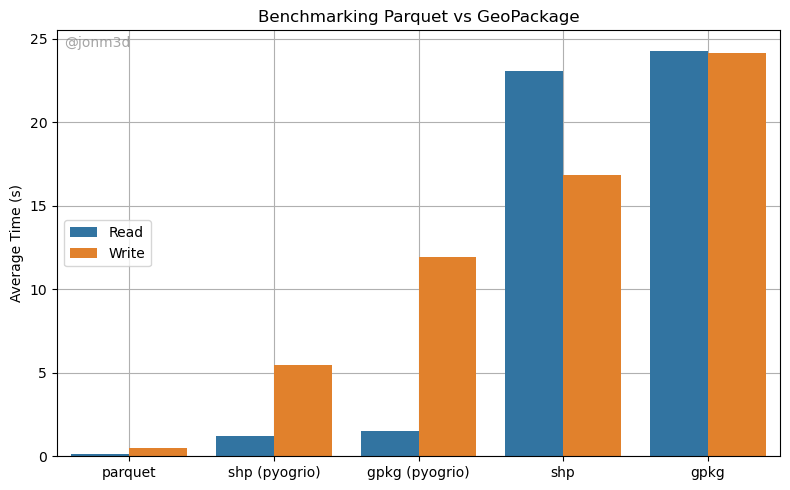

In [4]:
plt.figure(figsize=(8, 5))

sns.barplot(x='Format', y='value', hue='variable', data=melted_df, zorder=2)
plt.xlabel('')
plt.ylabel('Average Time (s)')
plt.title('Benchmarking Parquet vs GeoPackage')
plt.legend(loc='center left')

plt.annotate('@jonm3d',
             xy=(0.01, 0.96), 
             xycoords='axes fraction',
             fontsize=10, 
             alpha=0.7,
             color='grey')

plt.grid(zorder=1)

plt.tight_layout()

plt.savefig(os.path.join(bench_dir, 'speed_results.png'))

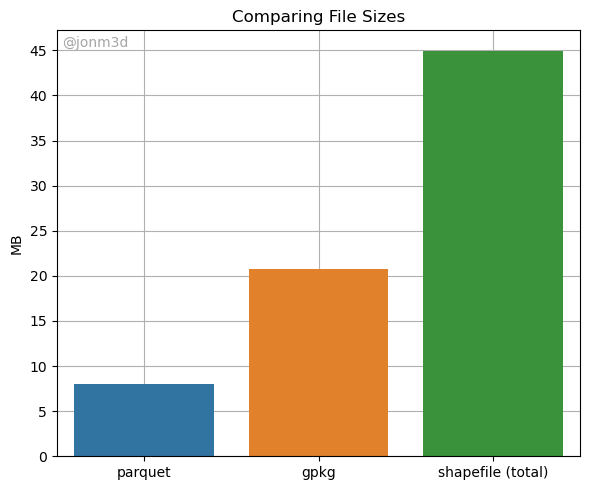

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path) / 1024 / 1024  # Convert to MB
    if file_path.endswith('.shp'):
        # For Shapefiles, also account for .shx, .dbf and any other potential sidecar files
        base_path = file_path[:-4]  # remove .shp extension
        for ext in ['.shx', '.dbf', '.prj', '.sbn', '.sbx', '.cpg']:
            sidecar_file = base_path + ext
            if os.path.exists(sidecar_file):
                size += os.path.getsize(sidecar_file) / 1024 / 1024
    return size


parquet_file_size = get_file_size(os.path.join(bench_dir, 'test.parquet'))
gpkg_file_size = get_file_size(os.path.join(bench_dir, 'test.gpkg'))
shp_file_size = get_file_size(os.path.join(bench_dir, 'test.shp'))
# fgb_file_size = get_file_size(os.path.join(bench_dir, 'test.fgb'))

# Create DataFrame to store results
size_results = {
    'Format': ['parquet', 'gpkg', 'shapefile (total)'],
    'MB': [parquet_file_size, gpkg_file_size, shp_file_size] #, fgb_file_size]
}
size_df = pd.DataFrame(size_results)

plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Format', y='MB', data=size_df, zorder=2)

plt.annotate('@jonm3d',
             xy=(0.01, 0.96), 
             xycoords='axes fraction',
             fontsize=10, 
             alpha=0.7,
             color='grey')

plt.grid(zorder=1)

# Setting integer only y-axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Comparing File Sizes')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(bench_dir, 'size_results.png'))


Let's make sure the data we read in both ways is actually the same and there wasn't some error in the read w.

In [6]:
def compare_geodataframes(gdf1, gdf2):
    # Check shape
    if gdf1.shape != gdf2.shape:
        return False

    # Check geometry equality
    if not gdf1.geometry.equals(gdf2.geometry):
        return False
    
    # Compare time columns if present
    if "time" in gdf1.columns and "time" in gdf2.columns:
        # Check if either geodataframe has time in datetime format
        if isinstance(gdf1["time"].iloc[0], pd.Timestamp):
            time1 = gdf1["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            time1 = gdf1["time"]

        if isinstance(gdf2["time"].iloc[0], pd.Timestamp):
            time2 = gdf2["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            time2 = gdf2["time"]

        if not (time1 == time2).all():
            print("Discrepancy found in the time column")
            return False

    # Check attribute data equality ignoring the column names
    for col_gdf1, col_gdf2 in zip(gdf1.drop(columns=["geometry", "time"]).columns, gdf2.drop(columns=["geometry", "time"]).columns):
        # Using numpy's isclose method to compare column values, considering floating point inaccuracies
        if not np.isclose(gdf1[col_gdf1], gdf2[col_gdf2], equal_nan=True).all():
            print(f"Discrepancy found in column: {col_gdf1}")
            return False

    return True



# Read data from each format into separate geodataframes
print("Reading test data...")
gdf_parquet = gpd.read_parquet(os.path.join(bench_dir, 'test.parquet'))
gdf_gpkg = gpd.read_file(os.path.join(bench_dir, 'test.gpkg'), engine="pyogrio")
gdf_shp = gpd.read_file(os.path.join(bench_dir, 'test.shp'), engine="pyogrio")
# gdf_fgb = gpd.read_file(os.path.join(bench_dir, 'test.fgb'), engine="pyogrio")

# We will compare all geodataframes with the parquet file as reference
gdfs = {
    'GeoPackage': gdf_gpkg,
    'Shapefile': gdf_shp,
    # 'FlatGeobuf': gdf_fgb
}

for name, gdf in gdfs.items():
    are_equal = compare_geodataframes(gdf_parquet, gdf)
    if are_equal:
        print(f'The data in the {name} file matches the Parquet data!')
    else:
        print(f'Something went wrong; the data in the {name} file is different now.')


Reading test data...
The data in the GeoPackage file matches the Parquet data!
The data in the Shapefile file matches the Parquet data!
